# LogGabor user guide


Table of content
----------------

* [What is the LogGabor package?](#What-is-the-LogGabor-package?) 

* [Properties of log-Gabor filters](LogGabor.ipynb#Properties-of-log-Gabor-filters)

* [Testing filter generation](LogGabor_testing-filter-generation.ipynb) 

* [Testing on a sample image](LogGabor.ipynb#Testing-on-a-sample-image) 

* [Building a pyramid](#Building-a-pyramid) 

* [An example of fitting images with log-Gabor filters](LogGabor_fit_example.ipynb) 

[Back to top](#LogGabor-user-guide)

## Importing the library

In [1]:
%load_ext autoreload
%autoreload 2
from LogGabor import LogGabor
parameterfile = 'https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py'
lg = LogGabor(parameterfile)


What do log Gabor functions look like in the spatial domain? Unfortunately due to the singularity in the log function at the origin one cannot construct an analytic expression for the shape of the log Gabor function in the spatial domain. One is reduced to designing the filters in the frequency domain and then performing a numerical inverse Fourier Transform to see what they look like. Their appearance is similar to Gabor functions though their shape becomes much "sharper" as the bandwidth is increased. The shapes of log Gabor and Gabor functions are almost identical for bandwidths less than one octave. 	


In [2]:
#import holoviews as hv
#hv.notebook_extension('bokeh')
#%load_ext holoviews.ipython
#%output size=150 dpi=120
import os
import numpy as np
np.set_printoptions(precision=2, suppress=True)
%matplotlib inline
import matplotlib.pyplot as plt
fig_width = 12
figsize=(fig_width, .618*fig_width)

In [3]:
from LogGabor import imread
image = imread('https://github.com/bicv/SLIP/raw/master/database/yelmo512.png')
print('Mean intensity: ', image.mean(), ' - standard deviation: ', image.std())

Mean intensity:  0.5346490691900253  - standard deviation:  0.22045908846780704


## Building a pyramid

In [4]:
figpath = '/tmp'
figpath = './figures/'
figpath = '../../Perrinet2015BICV_sparse/figures'
figpath = None
fig_width_pt = 318.670  # Get this from LaTeX using \showthe\columnwidth
fig_width_pt = 900
inches_per_pt = 1.0/72.27               # Convert pt to inches
fig_width = fig_width_pt*inches_per_pt  # width in inches

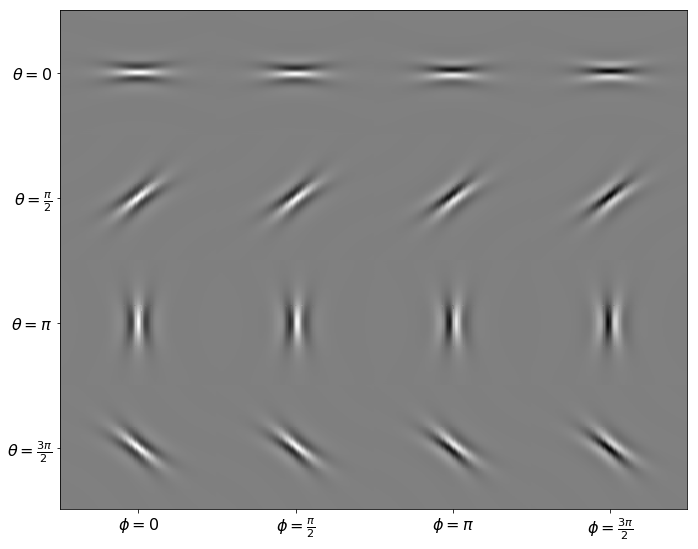

In [5]:
%matplotlib inline
# where should we store the figures generated by this notebook
phi = (np.sqrt(5)+1) / 2
fig = plt.figure(figsize=(fig_width, fig_width/phi))
border = 0.2
a = fig.add_axes((border, border*.5, .9-border, 1.-border*.5), facecolor='w')
a.axis(c='b', lw=0)

N_X_gabor = 128
lg = LogGabor(parameterfile)
lg.set_size((N_X_gabor, N_X_gabor))
samples = 4
image_gabor = np.zeros((N_X_gabor*samples, N_X_gabor*samples))
for i in range(samples):
    for j in range(samples):
        #params = {'sf_0':2**(2*j)/128., 'B_sf':pe.B_sf, 'theta':i*np.pi/4, 'B_theta':pe.B_theta}
        params = {'sf_0':1./16, 'B_sf':lg.pe.B_sf, 'theta':i*np.pi/samples, 'B_theta':lg.pe.B_theta}
        # loggabor takes as args: u, v, sf_0, B_sf, theta, B_theta)
        FT_lg = lg.loggabor(N_X_gabor/2, N_X_gabor/2, **params)
        image_temp = lg.invert(FT_lg * np.exp(-1j*np.pi*j/samples))
        image_gabor[(i*N_X_gabor):(i*N_X_gabor+N_X_gabor), (j*N_X_gabor):(j*N_X_gabor+N_X_gabor)] = image_temp
image_gabor /= np.abs(image_gabor).max()
lg.set_size(image_gabor)
fig, a = lg.imshow(image_gabor, fig=fig, ax=a)
a.set_xticks(np.arange(4)*N_X_gabor + N_X_gabor/2)
a.set_xticklabels([r'$\phi=0$', r'$\phi=\frac{\pi}{2}$', r'$\phi=\pi$', r'$\phi=\frac{3\pi}{2}$'], fontsize=16)
a.set_yticks(np.arange(4)*N_X_gabor + N_X_gabor/2)
a.set_yticklabels([r'$\theta=0$', r'$\theta=\frac{\pi}{2}$', r'$\theta=\pi$', r'$\theta=\frac{3\pi}{2}$'], fontsize=16)
a.grid(False)
if not(figpath is None): lg.savefig(fig, 'fig_log_gabor_filters_A', figpath=figpath)

Tiling of Fourier space using the pyramid

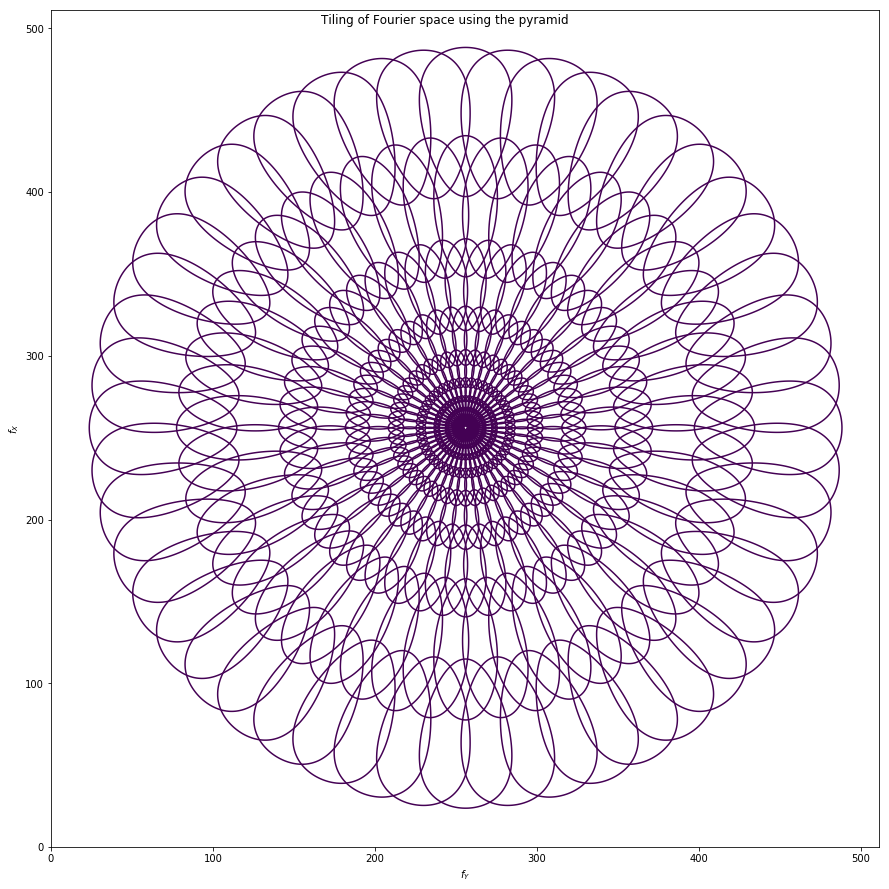

In [6]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
env_total = np.zeros_like(image)
for sf_0_ in lg.sf_0:
    for theta_ in lg.theta:
        for sym in [0, np.pi]:
            FT_lg = lg.loggabor(0, 0, sf_0=sf_0_, theta=theta_+sym, B_sf=lg.pe.B_sf,  B_theta=lg.pe.B_theta)
            env = np.absolute(FT_lg)**2
            env_total += env
            ax.contour(env, levels=[env.max()/2], lw=1)
fig.suptitle('Tiling of Fourier space using the pyramid')
ax.set_xlabel(r'$f_Y$')
ax.set_ylabel(r'$f_X$')
plt.tight_layout();

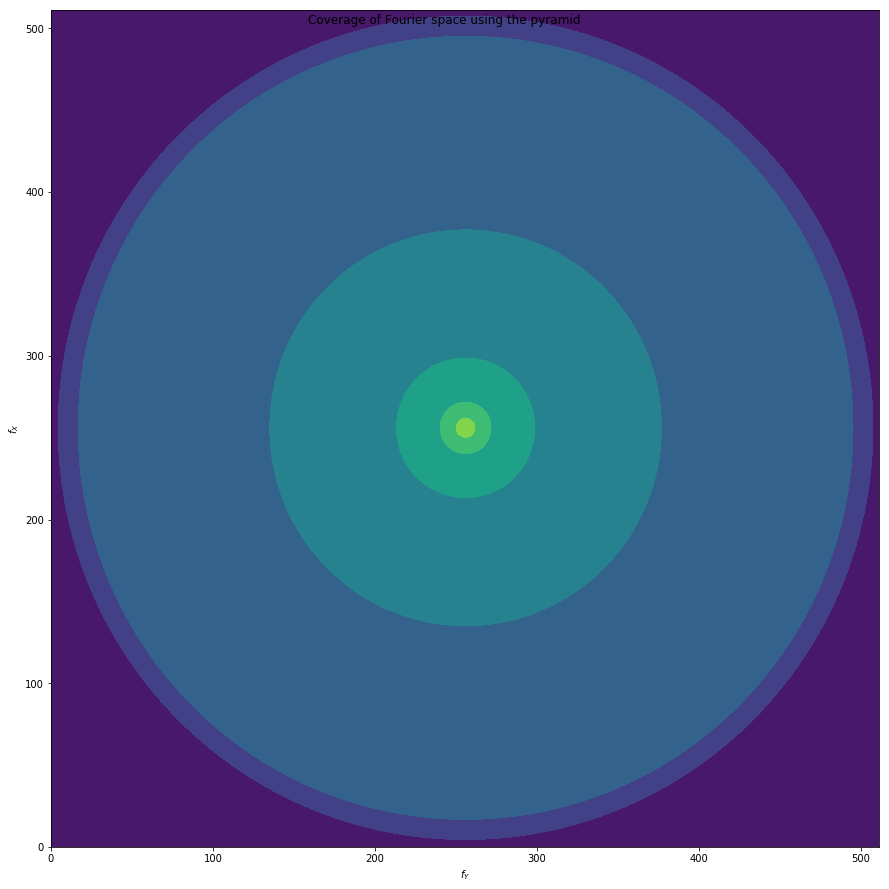

In [7]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax.contourf(np.log(env_total/env_total.max()+1.e-6))
fig.suptitle('Coverage of Fourier space using the pyramid')
ax.set_xlabel(r'$f_Y$')
ax.set_ylabel(r'$f_X$')
plt.tight_layout();

Now building a pyramid and displaying amplitude in the phase, orientation in the hue.

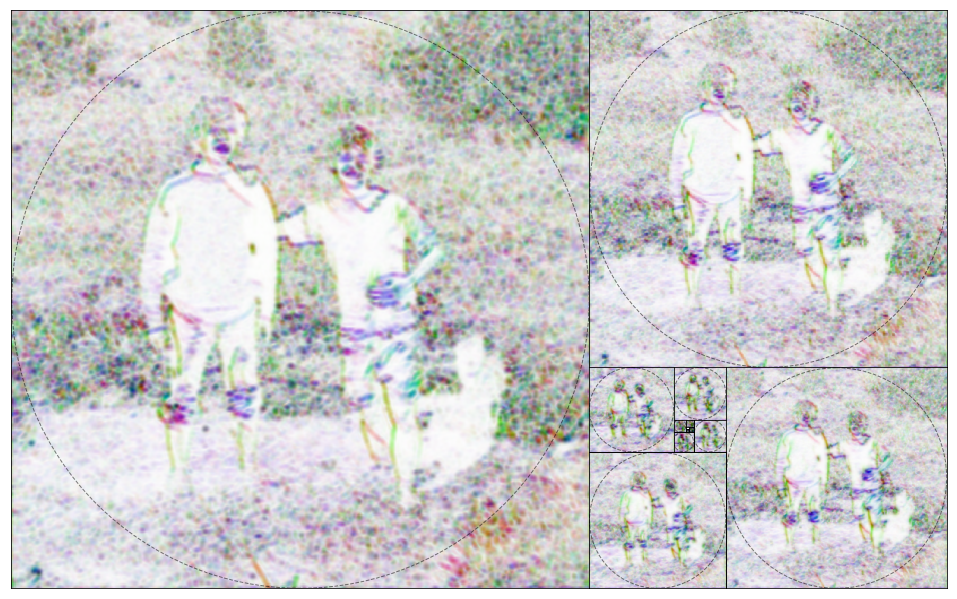

In [8]:
opts= {'vmin':0., 'vmax':1., 'interpolation':'nearest', 'origin':'upper'}

lg = LogGabor(parameterfile)
lg.set_size(image)
phi = (np.sqrt(5) +1.)/2. # golden number
lg.pe.base_levels = phi
lg.init()

C = lg.linear_pyramid(image)
fig, axs = lg.golden_pyramid(C, mask=lg.pe.do_mask, spiral=True)

if not(figpath is None): lg.savefig(fig, 'fig_log_gabor_filters_B', figpath=figpath)

The Golden Laplacian Pyramid. To represent the edges of the image at different levels, we may use a simple recursive approach constructing progressively a set of images of decreasing sizes, from a base to the summit of a pyramid. Using simple down-scaling and up-scaling operators we may approximate well a Laplacian operator. This is represented here by stacking images on a Golden Rectangle, that is where the aspect ratio is the golden section $\phi \hat{=} \frac{1+\sqrt{5}}{2}$. We present here the base image on the left and the successive levels of the pyramid in a clockwise fashion (for clarity, we stopped at level $11$). Note that here we also use $\phi^2$ (that is $\phi+1$) as the down-scaling factor so that the resolution of the pyramid images correspond across scales. Note at last that coefficient are very kurtotic: most are near zero, the distribution of coefficients has long tails. 

[Back to top](#LogGabor-user-guide)

## more book keeping

In [9]:
%load_ext watermark
%watermark

2018-03-20T10:13:06+01:00

CPython 3.6.4
IPython 6.2.1

compiler   : GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.39.2)
system     : Darwin
release    : 17.4.0
machine    : x86_64
processor  : i386
CPU cores  : 36
interpreter: 64bit


In [10]:
%load_ext version_information
%version_information numpy, scipy, matplotlib, SLIP, LogGabor

Software versions
Python 3.6.4 64bit [GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.39.2)]
IPython 6.2.1
OS Darwin 17.4.0 x86_64 i386 64bit
numpy 1.14.2
scipy 1.0.0
matplotlib 2.2.0
SLIP 20171205
LogGabor 2017-12-05.binder
Tue Mar 20 10:13:06 2018 CET

[Back to top](#LogGabor-user-guide)
[Back to the LogGabor user guide](LogGabor.ipynb#LogGabor-user-guide)